In [1]:
import os
import sys
import numpy as np
import pandas as pd
import eqtk

#For plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import plotnine as p9 #easier for some things

#For clustering
from fastdist import fastdist
import scipy.cluster.hierarchy as hcluster
from scipy.cluster.vq import whiten
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from scipy.spatial.distance import pdist



In [2]:
pwd = os.path.abspath('../..')
sys.path.append(os.path.join(pwd, 'code/')) 
import utilities
from utilities import *

In [3]:
#Set plotting defaults
sn.set_style('ticks')
mpl.rcParams.update({'text.color': 'black', 'axes.labelcolor': 'black', 
                     'xtick.color': 'black', 'ytick.color': 'black', 'figure.dpi':100, 'savefig.dpi':300,
                     'savefig.bbox': 'tight', 'savefig.transparent': True, 'mathtext.default':'regular'})
sn.set_context('notebook')
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
def scale_axis(mat, axis=0):
    mat_mn = np.expand_dims(mat.mean(axis = axis), axis)
    mat_sd = np.expand_dims(mat.std(axis = 0), axis)
    mat_scaled = (mat - mat_mn)/mat_sd
    return mat_scaled

Perform hierarchical clustering on the outputs from 1-input dimer networks of various sizes (3-6 monomers)
all simulated with the same output weights (see bottom of 20220617_sim1input_randomOutputWeights_highRes.ipynb). 

Run clustering on each parameter universe seperately since it will take too long to compute distances on 1000 universes X 1000 output weights. 

Save intermediate distance and linkage array in case we decide to change methods or thresholds later. 

In [5]:
#Using scipy for now. Later for efficiency, can write jitted distance function. Note, underwhelming performance with fastdist package
def hc_mat(mat, scale=False, axis=0, dist_metric='euclidean',
           link_method='centroid', cluster_criterion='distance', 
           threshold=3):
    """
    """
    if scale:
        mat = scale_axis(mat, axis=axis)
    
    mat_dist = pdist(mat.T, metric=dist_metric)
    mat_link = hcluster.linkage(mat_dist, method=link_method)
    mat_cluters = hcluster.fcluster(mat_link, threshold, criterion=cluster_criterion)
    return mat_dist, mat_link, mat_cluters

In [6]:
indir = '../../data/20220617_1input_randomParams_highRes/'
outdir = '../../data/20220617_1input_randomParams_highRes/hierarchical_clustering/'



In [7]:
# Loop through different size networks then through all universes within each network
dist_all = [0]*4
link_all = [0]*4
clusters_all = [0]*4

for m in range(3,7):
    outmat = np.load(f'{indir}output_{m}M_3activeDimers_1000k.npy')
    n_univ = outmat.shape[1]
    dist_combined = [0]*n_univ
    link_combined = [0]*n_univ
    clusters_combined = [0]*n_univ
    for univ in range(n_univ):
        dist_mat, link_mat, clusters = hc_mat(outmat[:,univ,:], scale=True, axis=0, dist_metric='euclidean',
                                          link_method='centroid', cluster_criterion='distance',
                                          threshold=3)
        dist_combined[univ] = dist_mat
        link_combined[univ] = link_mat
        clusters_combined[univ] = clusters
    
    dist_all[m-3] = np.stack(dist_combined)
    link_all[m-3] = np.stack(link_combined)
    clusters_all[m-3] = np.stack(clusters_combined)
    #save data
    np.save(os.path.join(outdir, f'hc_{m}M_3activeDimers_{n_univ}univ_dist.npy'), dist_all[m-3])
    np.save(os.path.join(outdir, f'hc_{m}M_3activeDimers_{n_univ}univ_linkage.npy'), link_all[m-3])
    np.save(os.path.join(outdir, f'hc_{m}M_3activeDimers_{n_univ}univ_clusters_thresh{3}.npy'), clusters_all[m-3])

    


Are there a greater number of clusters for certain parameter universes? 
Do certain parameter universes generate more distinct clusters? 
For the latter question, calculate the average curve for each cluster (within each universe)
then compute distances between average curves and see which universes have the largest (mean?) distance between
average curves. 

In [8]:
cluster_counts_all = [0] * 4
cluster_basis_all = [0] * 4
for m in range(4):
    clusters_mat = clusters_all[m]
    cluster_counts = np.apply_along_axis(lambda x: len(np.unique(x)), 1, clusters_mat)
    cluster_counts_all[m] = cluster_counts
    
    #Now compute basis curves
    outmat = np.load(os.path.join(indir, f'output_{m+3}M_3activeDimers_1000k.npy'))

    n_univ = clusters_all[m].shape[0]
    basis_combined = [0]*n_univ
    for univ in range(n_univ):
        outmat_scaled = scale_axis(outmat[:,univ,:], axis = 0)
        cluster_labels = clusters_mat[univ,:]
        clusters = np.unique(cluster_labels)
        basis = np.zeros((len(clusters), outmat_scaled.shape[0]))
        for i, clust in enumerate(clusters):
            cluster_ind = np.nonzero(cluster_labels == clust)[0]
            outmat_clust = outmat_scaled[:,cluster_ind]
            basis[i,:] = outmat_clust.mean(axis=1)
        basis_combined[univ] = basis
    
    cluster_basis_all[m] = basis_combined

In [9]:
cluster_counts_df = pd.DataFrame(np.vstack(cluster_counts_all).T, columns=[f'M={i}' for i in range(3,7)])
cluster_counts_df['univ'] = cluster_counts_df.index
cluster_counts_df_long = cluster_counts_df.melt(id_vars='univ', var_name='network_size', value_name='n_clusters')

In [21]:
p = (p9.ggplot(cluster_counts_df_long, p9.aes(x='n_clusters'))
 + p9.geom_histogram(binwidth = 1)
 + p9.theme_classic()
 + p9.facet_wrap('~network_size', nrow=1)
 + p9.xlab('number of clusters')
 + p9.theme(axis_text=p9.element_text(color='black'),
           aspect_ratio=1, strip_background=p9.element_blank()))
p.save('../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_cluster_histogram_3activeDimers_thresh3.pdf')


/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_cluster_histogram_3activeDimers_thresh3.pdf
/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Try larger threshold

In [12]:
thresh = 5
clusters_all_5 = [0]*4
n_univ = 1000
for m in range(4):
    clusters_combined = [0]*n_univ
    for univ in range(n_univ):
        clusters_combined[univ] = hcluster.fcluster(link_all[m][univ,:,:], thresh, criterion='distance')
    clusters_all_5[m] = np.stack(clusters_combined)


In [13]:
cluster_counts_all_5 = [0] * 4
for m in range(4):
    clusters_mat = clusters_all_5[m]
    cluster_counts = np.apply_along_axis(lambda x: len(np.unique(x)), 1, clusters_mat)
    cluster_counts_all_5[m] = cluster_counts

    
cluster_counts_5_df = pd.DataFrame(np.vstack(cluster_counts_all_5).T, columns=[f'M={i}' for i in range(3,7)])
cluster_counts_5_df['univ'] = cluster_counts_5_df.index
cluster_counts_5_df_long = cluster_counts_5_df.melt(id_vars='univ', var_name='network_size', value_name='n_clusters')  

/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


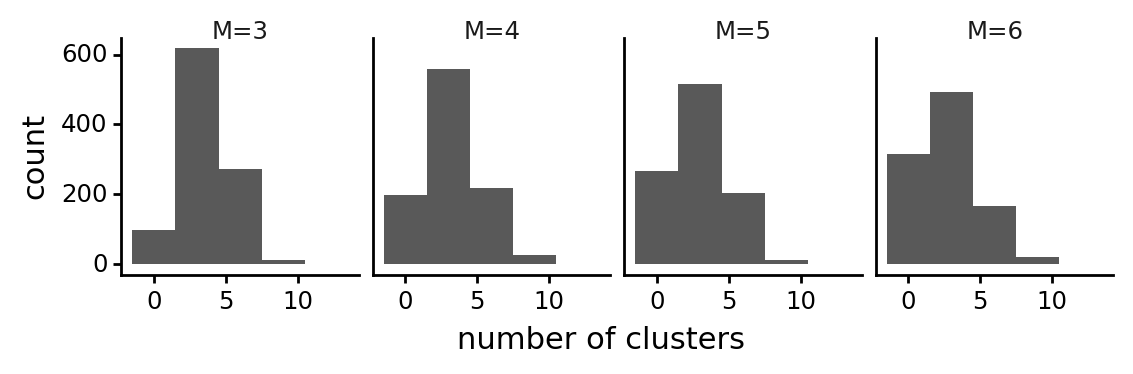

<ggplot: (8760483789069)>

In [14]:
(p9.ggplot(cluster_counts_5_df_long, p9.aes(x='n_clusters'))
 + p9.geom_histogram(binwidth = 3)
 + p9.theme_classic()
 + p9.facet_wrap('~network_size', nrow=1)
 + p9.xlab('number of clusters')
 + p9.theme(axis_text=p9.element_text(color='black'),
           aspect_ratio=1, strip_background=p9.element_blank()))
# p.save('../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_cluster_histogram_thresh5.pdf')


In [47]:
def plot_outcurves_clustered2(outmat, cluster_labels, shaded='max-min', clusters = None, 
                             percentiles=(0.05, 0.95), sample_n = 10, xticks = [0,4,9],
                             xticklabels = [-3,0,3], add_legend = False, plot_width=7, plot_height=10):
    """
    """
    if clusters is None: #plot all clusters  
        clusters = np.unique(cluster_labels)
    
    n_clusters = len(clusters)    
    # n_outweights = outmat.shape[2]
    n_titration = outmat.shape[0]
    
    xticklabels = [f'$10^{{{i}}}$' for i in xticklabels]
    fig, axes = plt.subplots(2, n_clusters, figsize=(n_clusters*plot_width, plot_height), squeeze=False, constrained_layout=True)
    for i, clust in enumerate(clusters):
        cluster_ind = np.nonzero(cluster_labels == clust)[0]
        outmat_clust = outmat[:,cluster_ind]
        clust_percent = np.round(outmat_clust.shape[1]/outmat.shape[1] * 100, 2)
        
        #Plot cluster average on the top row
        cluster_mean = outmat_clust.mean(axis=1)

        if shaded == 'max-min':
            cluster_lb = outmat_clust.min(axis=1)
            cluster_ub = outmat_clust.max(axis=1)
            label = 'max-min'
        elif shaded == 'percentile':
            cluster_lb = np.percentile(outmat_clust, percentiles[0], axis = 1)
            cluster_ub = np.percentile(outmat_clust, percentiles[1], axis = 1)
            label = f'{percentiles[0]}-{percentiles[1]} percentile'

        axes[(0,i)].plot(np.arange(n_titration), cluster_mean, label='average')
        axes[(0,i)].fill_between(np.arange(n_titration), cluster_lb, cluster_ub, alpha=0.2, label=label)
        
        #plot example curves on the bottom row
        if sample_n is not None and sample_n < outmat_clust.shape[1]:
            rand_ind = np.random.choice(np.arange(outmat_clust.shape[1]), size=sample_n, replace=False)
            outmat_clust = outmat_clust[:,rand_ind]
        for j in range(outmat_clust.shape[1]):
            axes[(1,i)].plot(np.arange(n_titration), outmat_clust[:,j])
        
        #Format axes
        axes[(0,i)].set(ylabel='out',xticks = xticks, xticklabels = xticklabels,
                        title=f'cluster: {clust}, {clust_percent}%')
        axes[(1,i)].set(ylabel='out',xticks = xticks, xticklabels = xticklabels,
                        title=f'example curves:')
        if add_legend:
                axes[(0,i)].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

    return fig, axes
        

In [25]:
univ_rand10 = np.random.choice(np.arange(1000), 10, replace=False)

for m in range(4):
    outmat = np.load(f'../../data/20220617_1input_randomParams_highRes/output_{m+3}M_3activeDimers_1000k.npy')
    
    clusters = clusters_all[m]
    for univ in univ_rand10:
        outmat_scaled = scale_axis(outmat[:,univ,:])
        
        fig1, axes1 = plot_outcurves_clustered2(outmat_scaled, clusters[univ,:], 
                                               shaded='max-min',
                                               xticks = [0,49,99],
                                               xticklabels = [-3,0,3], add_legend = True)
        fig1.suptitle(f'Universe {univ}')
        fig1.savefig(f'../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_curves_{m+3}M_univ{univ}_3activeDimers_thresh3.pdf')
        plt.close()


Compute meta clusters

In [36]:
meta_link_all_thresh3 = [0]*4
meta_clust_all_thresh3 = [0]*4
for m in range(4):
    cluster_basis_combined = np.vstack(cluster_basis_all[m])
    
    meta_dist_combined, meta_link_combined, meta_clust_combined = \
    hc_mat(cluster_basis_combined.T, scale=False, threshold=3)
    
    #save data
    meta_link_all_thresh3[m] = meta_link_combined
    meta_clust_all_thresh3[m] = meta_clust_combined
    
    np.save(os.path.join(outdir, f'hc_{m+3}M_3activeDimers_meta_dist_thresh3.npy'), meta_dist_combined)
    np.save(os.path.join(outdir, f'hc_{m+3}M_3activeDimers_meta_linkage_thresh3.npy'), meta_link_combined)
    np.save(os.path.join(outdir, f'hc_{m+3}M_3activeDimers_meta_clusters_thresh3.npy'), meta_clust_combined)

Count the number of meta cluster across different network sizes

In [37]:
meta_clust_count_df = pd.DataFrame({'network_size': [f'm={i+3}' for i in range(4)], 
                                    'n_clusters':[i.max() for i in meta_clust_all_thresh3]})

In [39]:
p=(p9.ggplot(meta_clust_count_df, p9.aes(x='network_size', y='n_clusters'))
 +p9.geom_bar(stat='identity')
 +p9.theme_classic()
 +p9.ylab('number of meta clusters')
 +p9.xlab('network size')
 +p9.theme(axis_text=p9.element_text(color='black')))
p.save('../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_metaClusters_histogram_3activeDimers_thresh3.pdf')


/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_metaClusters_histogram_3activeDimers_thresh3.pdf


Plot random meta clusters

In [ ]:
for m in range(4):
    clust_rand10 = np.random.choice(np.arange(meta_clust_3randAD_all_thresh3[m].max()), 10, replace=False)
    
    cluster_basis_combined = np.vstack(cluster_basis_3randAD_all[m])
    
    fig1, axes1 = plot_outcurves_clustered2(cluster_basis_combined.T, 
                                            meta_clust_3randAD_all_thresh3[m],
                                            clusters=clust_rand10, shaded='max-min', xticks = [0,49,99],
                                            xticklabels = [-3,0,3], add_legend = True)
    fig1.savefig(f'../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_curves_{m+3}M_3randomActiveDimers_metaclusters_thresh3.pdf')
    plt.close()

Now try with output from random networks allowing the choice of active dimers to vary

In [20]:
dist_all = [0]*4
link_all = [0]*4
clusters_all = [0]*4

for m in range(3,7):
    outmat = np.load(f'{indir}output_{m}M_3randomActiveDimers_1000k.npy')
    n_univ = outmat.shape[1]
    dist_combined = [0]*n_univ
    link_combined = [0]*n_univ
    clusters_combined = [0]*n_univ
    for univ in range(n_univ):
        dist_mat, link_mat, clusters = hc_mat(outmat[:,univ,:], scale=True, axis=0, dist_metric='euclidean',
                                          link_method='centroid', cluster_criterion='distance',
                                          threshold=3)
        dist_combined[univ] = dist_mat
        link_combined[univ] = link_mat
        clusters_combined[univ] = clusters
    
    dist_all[m-3] = np.stack(dist_combined)
    link_all[m-3] = np.stack(link_combined)
    clusters_all[m-3] = np.stack(clusters_combined)
    #save data
    np.save(os.path.join(outdir, f'hc_{m}M_3randomActiveDimers_{n_univ}univ_dist.npy'), dist_all[m-3])
    np.save(os.path.join(outdir, f'hc_{m}M_3randomActiveDimers_{n_univ}univ_linkage.npy'), link_all[m-3])
    np.save(os.path.join(outdir, f'hc_{m}M_3randomActiveDimers_{n_univ}univ_clusters_thresh{3}.npy'), clusters_all[m-3])

    


In [22]:
cluster_counts_3randAD_all = [0] * 4
cluster_basis_3randAD_all = [0] * 4
for m in range(4):
    clusters_mat = clusters_all[m]
    cluster_counts = np.apply_along_axis(lambda x: len(np.unique(x)), 1, clusters_mat)
    cluster_counts_3randAD_all[m] = cluster_counts
    
    #Now compute basis curves
    outmat = np.load(os.path.join(indir, f'output_{m+3}M_3randomActiveDimers_1000k.npy'))

    n_univ = clusters_all[m].shape[0]
    basis_combined = [0]*n_univ
    for univ in range(n_univ):
        outmat_scaled = scale_axis(outmat[:,univ,:], axis = 0)
        cluster_labels = clusters_mat[univ,:]
        clusters = np.unique(cluster_labels)
        basis = np.zeros((len(clusters), outmat_scaled.shape[0]))
        for i, clust in enumerate(clusters):
            cluster_ind = np.nonzero(cluster_labels == clust)[0]
            outmat_clust = outmat_scaled[:,cluster_ind]
            basis[i,:] = outmat_clust.mean(axis=1)
        basis_combined[univ] = basis
    
    cluster_basis_3randAD_all[m] = basis_combined

In [23]:
cluster_counts_3randAD_df = pd.DataFrame(np.vstack(cluster_counts_3randAD_all).T, columns=[f'M={i}' for i in range(3,7)])
cluster_counts_3randAD_df['univ'] = cluster_counts_3randAD_df.index
cluster_counts_3randAD_df_long = cluster_counts_3randAD_df.melt(id_vars='univ', var_name='network_size', value_name='n_clusters')

In [24]:
p = (p9.ggplot(cluster_counts_3randAD_df_long, p9.aes(x='n_clusters'))
 + p9.geom_histogram(binwidth = 1)
 + p9.theme_classic()
 + p9.facet_wrap('~network_size', nrow=1)
 + p9.xlab('number of clusters')
 + p9.theme(axis_text=p9.element_text(color='black'),
           aspect_ratio=1, strip_background=p9.element_blank()))
p.save('../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_cluster_histogram_3randomActiveDimers_thresh3.pdf')


/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_cluster_histogram_3randomActiveDimers_thresh3.pdf
/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [26]:
univ_rand10 = np.random.choice(np.arange(1000), 10, replace=False)

for m in range(4):
    outmat = np.load(f'../../data/20220617_1input_randomParams_highRes/output_{m+3}M_3randomActiveDimers_1000k.npy')
    
    clusters = clusters_all[m]
    for univ in univ_rand10:
        outmat_scaled = scale_axis(outmat[:,univ,:])
        
        fig1, axes1 = plot_outcurves_clustered2(outmat_scaled, clusters[univ,:], 
                                               shaded='max-min',
                                               xticks = [0,49,99],
                                               xticklabels = [-3,0,3], add_legend = True)
        fig1.suptitle(f'Universe {univ}')
        fig1.savefig(f'../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_curves_{m+3}M_univ{univ}_3randomActiveDimers_thresh3.pdf')
        plt.close()


Compute meta clusters

In [40]:
meta_link_3randAD_all_thresh3 = [0]*4
meta_clust_3randAD_all_thresh3 = [0]*4
for m in range(4):
    cluster_basis_3randAD_combined = np.vstack(cluster_basis_3randAD_all[m])
    
    meta_dist_combined, meta_link_combined, meta_clust_combined = \
    hc_mat(cluster_basis_3randAD_combined.T, scale=False, threshold=3)
    
    #save data
    meta_link_3randAD_all_thresh3[m] = meta_link_combined
    meta_clust_3randAD_all_thresh3[m] = meta_clust_combined
    
    np.save(os.path.join(outdir, f'hc_{m+3}M_3randomActiveDimers_meta_dist_thresh3.npy'), meta_dist_combined)
    np.save(os.path.join(outdir, f'hc_{m+3}M_3randomActiveDimers_meta_linkage_thresh3.npy'), meta_link_combined)
    np.save(os.path.join(outdir, f'hc_{m+3}M_3randomActiveDimers_meta_clusters_thresh3.npy'), meta_clust_combined)

In [41]:
meta_clust_count_3randAD_df = pd.DataFrame({'network_size': [f'm={i+3}' for i in range(4)], 
                                    'n_clusters':[i.max() for i in meta_clust_3randAD_all_thresh3]})

In [45]:
p=(p9.ggplot(meta_clust_count_3randAD_df, p9.aes(x='network_size', y='n_clusters'))
 +p9.geom_bar(stat='identity')
 +p9.theme_classic()
 +p9.ylab('number of meta clusters')
 +p9.xlab('network size')
 +p9.theme(axis_text=p9.element_text(color='black')))
p.save('../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_metaClusters_histogram_3randomActiveDimers_thresh3.pdf')


/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_metaClusters_histogram_3randomActiveDimers_thresh3.pdf


In [48]:

for m in range(4):
    clust_rand10 = np.random.choice(np.arange(meta_clust_3randAD_all_thresh3[m].max()), 10, replace=False)
    
    cluster_basis_combined = np.vstack(cluster_basis_3randAD_all[m])
    
    fig1, axes1 = plot_outcurves_clustered2(cluster_basis_combined.T, 
                                            meta_clust_3randAD_all_thresh3[m],
                                            clusters=clust_rand10, shaded='max-min', xticks = [0,49,99],
                                            xticklabels = [-3,0,3], add_legend = True)
    fig1.savefig(f'../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_curves_{m+3}M_3randomActiveDimers_metaclusters_thresh3.pdf')
    plt.close()
